# BEM-BEM coupling of Poisson-Boltzmann - spherical domain

## Entry data

In [1]:
import dolfin
import bempp.api
from bempp.api.external.fenics import FenicsOperator
from dolfin_utils.meshconvert import meshconvert
import numpy as np
from bempp.api.external import fenics
from scipy.sparse.linalg import cg, minres
import pylab as plt
import time

from scipy.sparse.linalg import gmres
from scipy.sparse.linalg import LinearOperator
from bempp.api.assembly.discrete_boundary_operator import InverseSparseDiscreteBoundaryOperator
from bempp.api.assembly.blocked_operator import BlockedDiscreteOperator

from bempp.api.operators.boundary import sparse, laplace, modified_helmholtz
from bempp.api.operators.potential import laplace as lp
 
# Solver data #
tol = 1e-06         # Tolerance
fmm = 0             # Use FMM

# Problem data #
Q = np.array([1.0,1.0,0.75])                           # Charges
PC=np.array([[1,0,0],[0.7,0.7,0],[-0.5,-0.5,0]])       # Points of charges
R = np.array([2., 2., 2.])                             # Radiuses
w = 0.1250                                             # kappa
es = 80.                                               # External permitivity (solvant)
em = 4.                                                # Internal permitivity (molecule)

ec = 1.602176e-19 #[C]
kb = 1.380648e-23 #[J/K]
T  = 300 #[K]
S1 = 1 #(ec/(kb*T))  #38.681 [C/J]

# Result collecting lists #
solv_error = []
mesh_size = []
iter_num = []
time_solve = []

# Iteratotion for mesh #
grid_size = [0, 1, 2, 3]#, 4]

# Analytical solvation energy #
from an_solution import an_P
Ri = R[0]
G2 = an_P(Q, PC, em, es, Ri, w, Ri , 10)
print(G2)

# RHS functions #
@bempp.api.real_callable(jit=False)
def RHS_M(x, n, domain_index, result):
    global Q,PC,em,es,S1
    result[:] = (S1 / (4.*np.pi*es))  * np.sum( Q / np.linalg.norm( x - PC, axis=1))

@bempp.api.real_callable(jit=False)
def RHS_S(x, n, domain_index, result):
    global Q,PC,em,es,S1
    result[:] = -(S1/(4.*np.pi*es))   * np.sum( np.dot( x - PC , n)  * Q / (np.linalg.norm( x - PC , axis=1)**3) )


-164.33752347454015


## Solving problems for each of the mesh

In [2]:
for m in grid_size:
    ######################### Mesh and spaces ##################################
    import os.path

    # Using the same mesh as for FEM-BEM for comparison #
    if not os.path.isfile("mesh_sphere_"+format(m)+".xml"):
        mesh_file = "Sphere_R_"+format(Ri)+"_h_2_"+format(m)+".msh"
        meshconvert.gmsh2xml(mesh_file, "mesh_sphere_"+format(m)+".xml", iformat=None)
        
    mesh = dolfin.Mesh("mesh_sphere_"+format(m)+".xml")  
     
    nor = dolfin.FacetNormal(mesh) 
    
    # Spaces for FEM and BEM #
    fenics_space = dolfin.FunctionSpace(mesh, "CG", 1)
    trace_space, trace_matrix = \
        fenics.fenics_to_bempp_trace_data(fenics_space)
    bempp_space = bempp.api.function_space(trace_space.grid, "P", 1)
    
    del fenics_space
    del trace_matrix

    # Mesh size information #
    print("BEM dofs: {0}".format(bempp_space.global_dof_count))
    hmax = trace_space.grid.maximum_element_diameter
    mesh_size.append(hmax)
    
    # BEM operators #
    id_op = bempp.api.operators.boundary.sparse.identity(trace_space, trace_space, trace_space)
    mass = bempp.api.operators.boundary.sparse.identity(bempp_space, bempp_space, bempp_space)

    if fmm:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, trace_space, trace_space, assembler="fmm")
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, trace_space, assembler="fmm")
        adlp_0 = bempp.api.operators.boundary.laplace.adjoint_double_layer(bempp_space, bempp_space, bempp_space, assembler="fmm")
        hslp_0 = bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, bempp_space, assembler="fmm")

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, trace_space, trace_space, w, assembler="fmm")
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, trace_space, trace_space, w, assembler="fmm")
        adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(bempp_space, bempp_space, bempp_space, w, assembler="fmm")
        hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(trace_space, bempp_space, bempp_space, w, assembler="fmm")
    else:
        dlp_0 = bempp.api.operators.boundary.laplace.double_layer(trace_space, trace_space, trace_space)
        slp_0 = bempp.api.operators.boundary.laplace.single_layer(bempp_space, trace_space, trace_space)
        adlp_0 = bempp.api.operators.boundary.laplace.adjoint_double_layer(bempp_space, bempp_space, bempp_space)
        hslp_0 = bempp.api.operators.boundary.laplace.hypersingular(trace_space, bempp_space, bempp_space)

        dlp = bempp.api.operators.boundary.modified_helmholtz.double_layer(trace_space, trace_space, trace_space, w)
        slp = bempp.api.operators.boundary.modified_helmholtz.single_layer(bempp_space, trace_space, trace_space, w)
        adlp = bempp.api.operators.boundary.modified_helmholtz.adjoint_double_layer(bempp_space, bempp_space, bempp_space, w)
        hslp = bempp.api.operators.boundary.modified_helmholtz.hypersingular(trace_space, bempp_space, bempp_space, w)
    
    RHS_in = bempp.api.GridFunction(trace_space, fun=RHS_M)
    RHS_out = bempp.api.GridFunction(bempp_space, fun=RHS_S)

    ######################### Matrix and RHS ##################################
    
    # RHS
    rhs_M = RHS_in.projections(trace_space)
    rhs_S = RHS_out.projections(bempp_space)
    rhs = np.concatenate([rhs_M, rhs_S])
    
    blocks = [[None,None],[None,None]]
    
    # Solvant case
    B00 = (.5*(1.+em/es)*id_op + (em/es*dlp_0 - dlp)).weak_form()
    B01 = -(slp_0-slp).weak_form()
    B10 = em/es*(hslp - hslp_0).weak_form()
    B11 = (.5*(1.+em/es)*mass - (adlp_0 - em/es*adlp)).weak_form()
    blocks[0][0] = B00  
    blocks[0][1] = B01  
    blocks[1][0] = B10  
    blocks[1][1] = B11  

    blocked = BlockedDiscreteOperator(np.array(blocks))
    
    ######################### Preconditioner and solvers ##################################
    # Mass matrix preconditioner #
    PM = InverseSparseDiscreteBoundaryOperator(
        bempp.api.operators.boundary.sparse.identity(
            bempp_space, bempp_space, bempp_space).weak_form())

    # Create a block diagonal preconditioner object using the Scipy LinearOperator class
    def apply_prec(x):
        """Apply the block diagonal preconditioner"""
        m1 = PM.shape[0]
        m2 = PM.shape[0]
        n1 = PM.shape[1]
        n2 = PM.shape[1]

        res1 = PM.dot(x[:n1])
        res2 = PM.dot(x[n1:])
        return np.concatenate([res1, res2])

    p_shape = (PM.shape[0] + PM.shape[0], PM.shape[1] + PM.shape[1])
    P = LinearOperator(p_shape, apply_prec, dtype=np.dtype('float64'))

    it_count = 0
    def count_iterations(x):
        global it_count
        it_count += 1

    from scipy.sparse.linalg import gmres
    start = time.time()     
    soln, info = gmres(blocked, rhs, M=P, callback=count_iterations, tol=tol, restrt=500)  
    end = time.time()
    curr_time = (end - start) 
    time_solve.append(curr_time) 
    
    soln_u = soln[:trace_space.global_dof_count]
    soln_lambda = soln[trace_space.global_dof_count:]

    print("Number of iterations: {0}".format(it_count))
    iter_num.append(it_count)
    
    dirichlet_fun = bempp.api.GridFunction(trace_space, coefficients=soln_u)
    neumann_fun = bempp.api.GridFunction(bempp_space, coefficients=es/em*soln_lambda)
    
    ######################### Solvation energy ##################################
    
    slpF = bempp.api.operators.potential.laplace.single_layer(bempp_space, np.transpose(PC)) 
    dlpF = bempp.api.operators.potential.laplace.double_layer(trace_space, np.transpose(PC))

    uF = slpF * neumann_fun - dlpF * dirichlet_fun
    
    q_uF = 0
    for i in range(len(PC)):
        Sum = (uF[0][i].real)*Q[i]
        q_uF = q_uF + Sum

    E_Solv = 0.5*4.*np.pi*332.064*(q_uF) 
    print('Energia de Solvatacion : {:7.3f} [kCal/mol]'.format(E_Solv))
    Error = np.abs( E_Solv/G2-1 )*100
    print('{:.4f}%'.format(Error))
    solv_error.append(Error)  

BEM dofs: 116


/usr/lib/python3/dist-packages/scipy/sparse/linalg/dsolve/linsolve.py:296: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


Number of iterations: 6
Energia de Solvatacion : -167.894 [kCal/mol]
2.1643%
BEM dofs: 316
Number of iterations: 6
Energia de Solvatacion : -165.535 [kCal/mol]
0.7285%
BEM dofs: 1062
Number of iterations: 6
Energia de Solvatacion : -164.703 [kCal/mol]
0.2226%
BEM dofs: 4184
Number of iterations: 6
Energia de Solvatacion : -164.427 [kCal/mol]
0.0542%


## Ploting the results in comparison to FEM-BEM coupling formulations

## Convergence plot

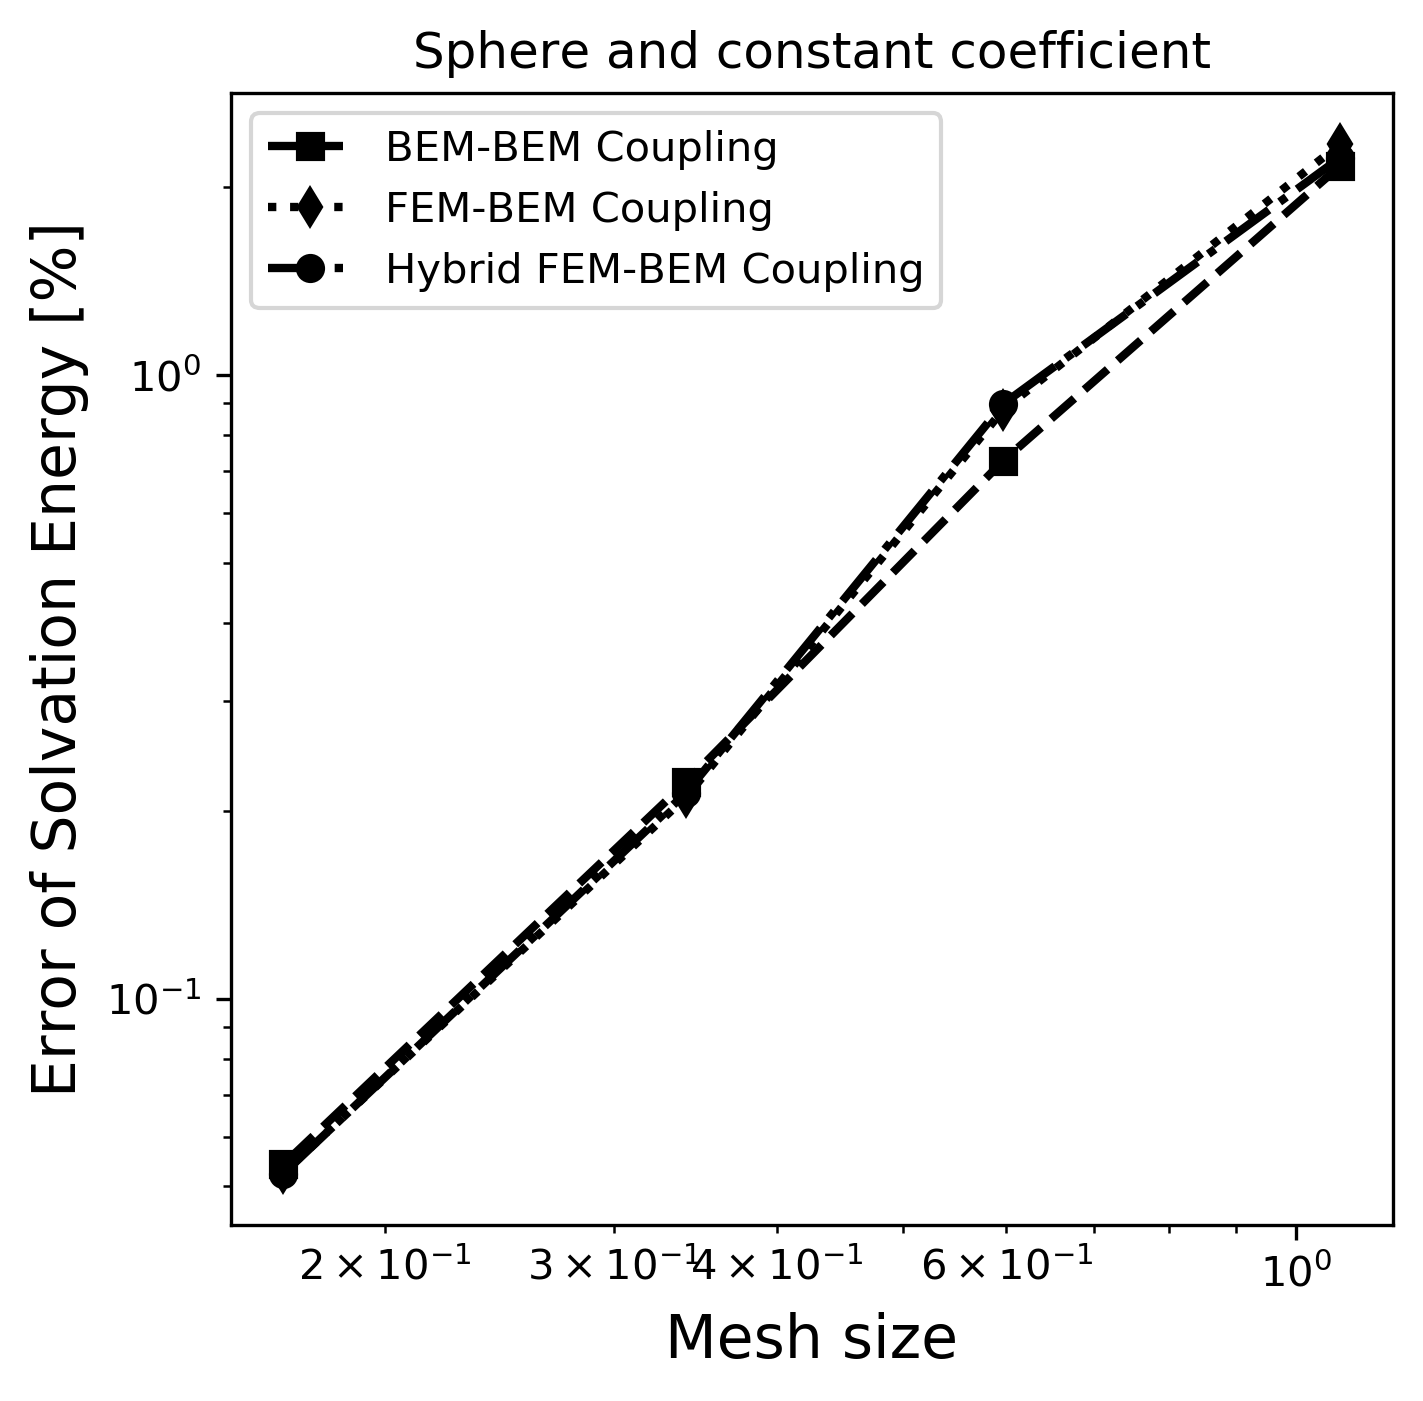

In [3]:
from operator import add
import matplotlib.pyplot as plt

with open('FEM_BEM_Sphere_Const_error.npy', 'rb') as f:
     FEM_BEM_solv_error = np.load(f)

with open('Hybrid_FEM_BEM_Sphere_Const_error.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_error = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, solv_error, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(mesh_size, FEM_BEM_solv_error, 'kd:', linewidth=2, label='FEM-BEM Coupling')
plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_error, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
# plt.loglog(mesh_size, o_mesh_size, 'k:', linewidth=1, label='O(h)')
plt.legend(loc='upper left')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Error of Solvation Energy [%]', fontsize='x-large')
plt.show()

## Iteration count

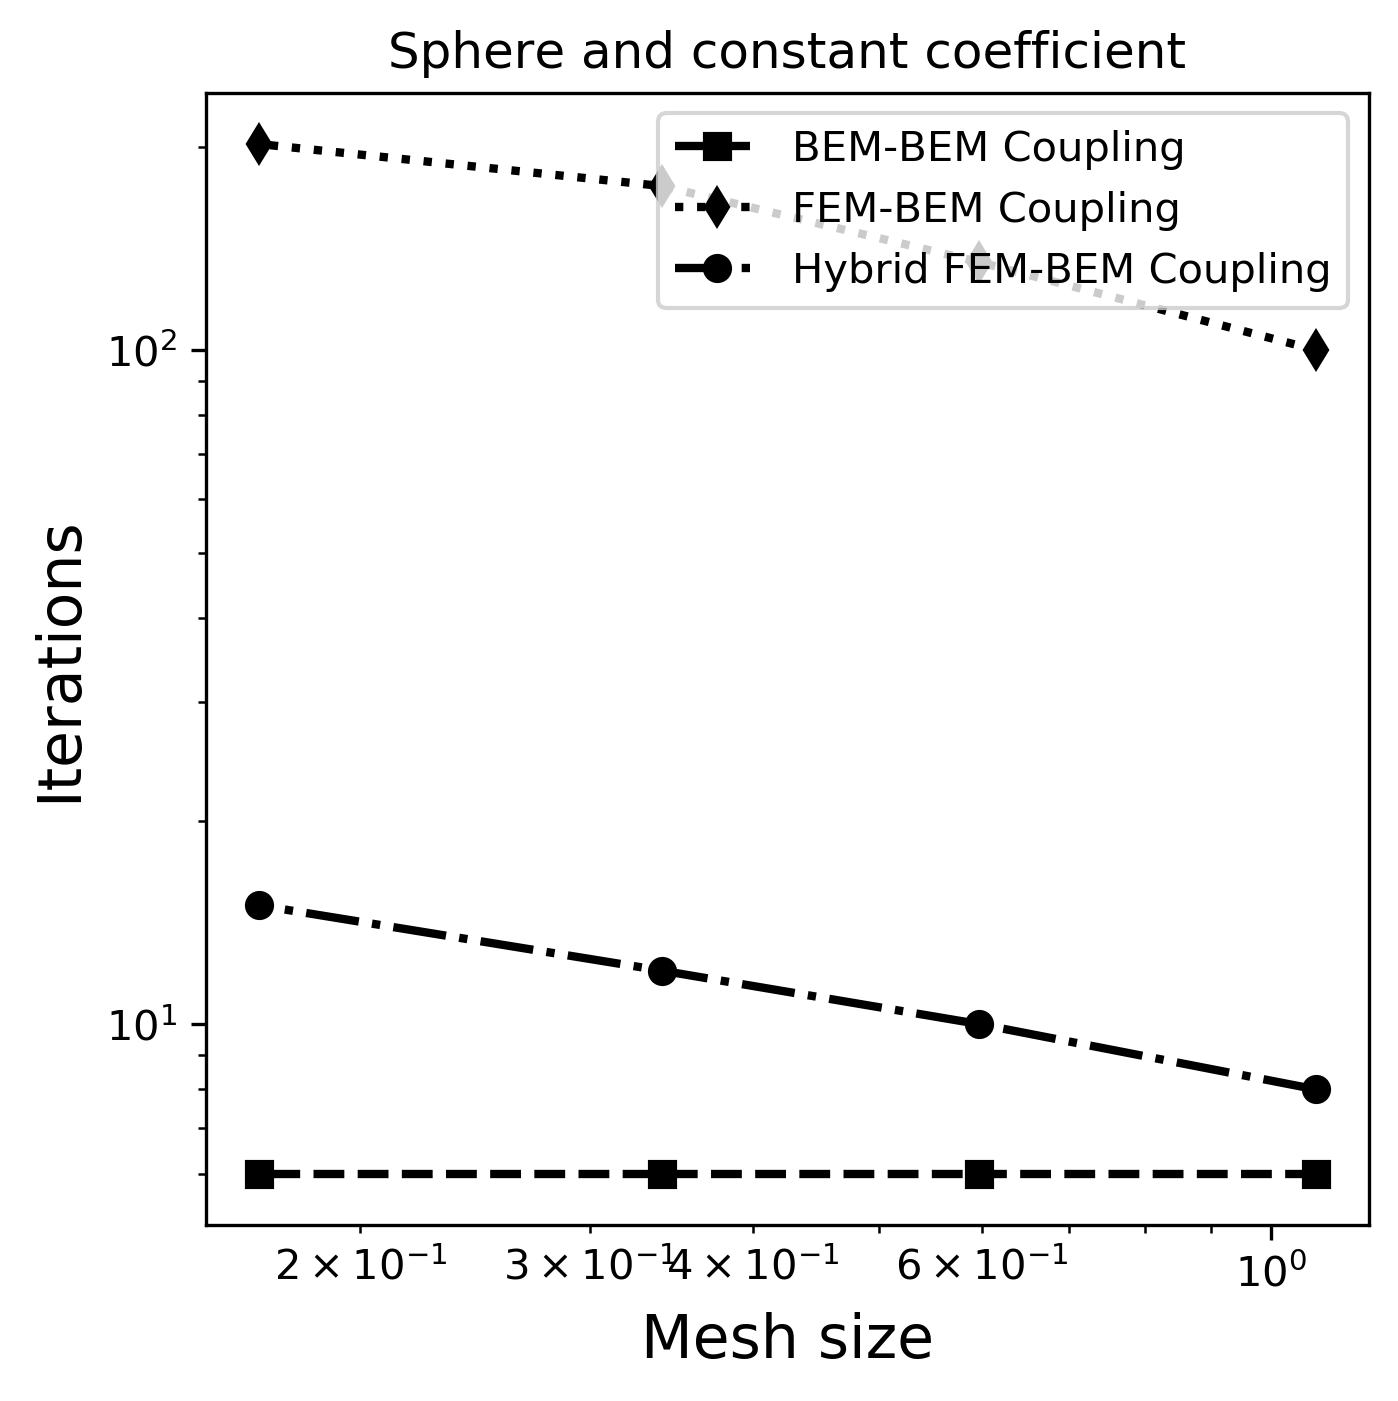

In [7]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_iter.npy', 'rb') as f:
     FEM_BEM_solv_iter = np.load(f)

with open('Hybrid_FEM_BEM_Sphere_Const_iter.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_iter = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, iter_num, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(mesh_size, FEM_BEM_solv_iter, 'kd:', linewidth=2, label='FEM-BEM Coupling')
plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_iter, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Iterations', fontsize='x-large')
plt.show()

## Computational cost

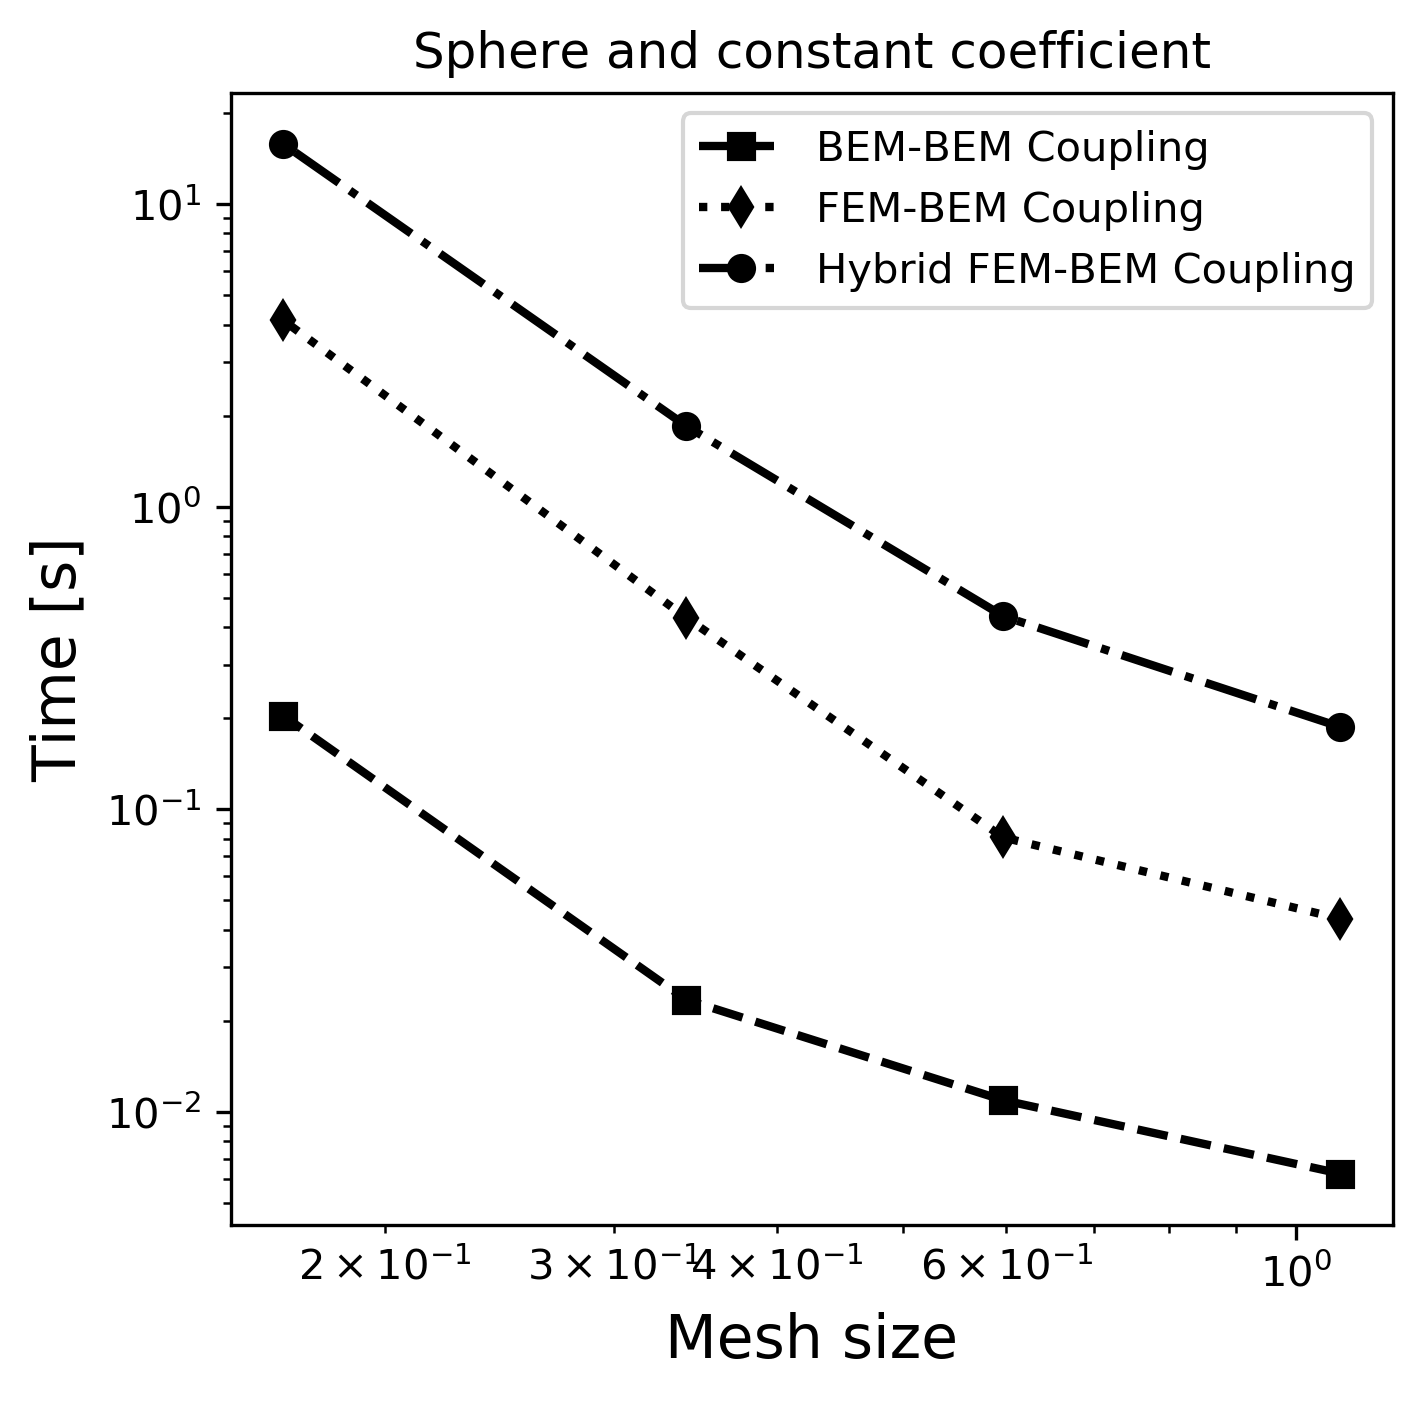

In [8]:
import matplotlib.pyplot as plt

log_mesh_size = np.log(mesh_size)

with open('FEM_BEM_Sphere_Const_time.npy', 'rb') as f:
     FEM_BEM_solv_time = np.load(f)

with open('Hybrid_FEM_BEM_Sphere_Const_time.npy', 'rb') as f:
     Hybrid_FEM_BEM_solv_time = np.load(f)

plt.figure( figsize=(5, 5), dpi=300)
plt.loglog(mesh_size, time_solve, 'ks--', linewidth=2, label='BEM-BEM Coupling')
plt.loglog(mesh_size, FEM_BEM_solv_time, 'kd:', linewidth=2, label='FEM-BEM Coupling')
plt.loglog(mesh_size, Hybrid_FEM_BEM_solv_time, 'ko-.', linewidth=2, label='Hybrid FEM-BEM Coupling')
plt.legend(loc='upper right')
plt.title('Sphere and constant coefficient')
plt.xlabel('Mesh size', fontsize='x-large')
plt.ylabel('Time [s]', fontsize='x-large')
plt.show()